In [ ]:
import sys
training_src_path = '/home/poulpos/pigs/animal-spot/TRAINING'
sys.path.insert(1, training_src_path)

In [ ]:
import os
from start_training import setup_training
trainer = setup_training(os.path.join(training_src_path, "config"))
trainer.init_logger()
trainer.read_config()
trainer.start_training()

In [1]:
import pandas as pd

# Learning infos

In [82]:
def read_log(file, start_line=1):
    with open(file) as f:
        lines = [line.rstrip() for i, line in enumerate(f) if i >= start_line]
    df = pd.DataFrame(columns=["type", "epoch", "loss","tp","tn","fp","fn","accuracy","f1","precision","TPR","FPR","t"])
    for line in lines:
        current = {}
        infos = line.split("|")
        if len(infos) >= 2 and infos[1] == "D":
            continue
        if len(infos) < 5:
            print(f"Can't understand the following line\n  {line}")
        current["type"] = infos[2]
        current["epoch"] = infos[3]
        for i in range(4, len(infos)):
            vv = infos[i].split(":")
            if len(vv) != 2:
                print(f"line {line} rank {i}")
                continue
            [var, val] = vv
            current[var] = float(val)
        row = pd.DataFrame(data={k:[v] for k,v in current.items() if k != "lr"})
        df = pd.concat([df, row], ignore_index=True)
    return df



In [113]:
train_df = read_log("/home/poulpos/pigs/log/TRAIN-nw8.log") #, start_line=141)

/tmp/ipykernel_13171/667899763.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row], ignore_index=True)


In [114]:
train_df.head()

type epoch   loss      tp      tn     fp     fn  accuracy     f1  \
0  train     1  0.116  4814.0  6988.0  236.0  234.0     0.962  0.953   
1  train     2  0.091  4859.0  7044.0  181.0  188.0     0.970  0.963   
2    val     2  0.222  1077.0  1393.0  224.0    6.0     0.915  0.904   
3  train     3  0.076  4906.0  7067.0  157.0  142.0     0.976  0.970   
4  train     4  0.056  4930.0  7113.0  114.0  115.0     0.981  0.977   

   precision    TPR    FPR       t  
0      0.953  0.954  0.033  1148.5  
1      0.964  0.963  0.025  1213.2  
2      0.828  0.994  0.139   116.2  
3      0.969  0.972  0.022  1714.0  
4      0.977  0.977  0.016  1728.2

In [85]:
import matplotlib.pyplot as plt

<Axes: xlabel='epoch'>

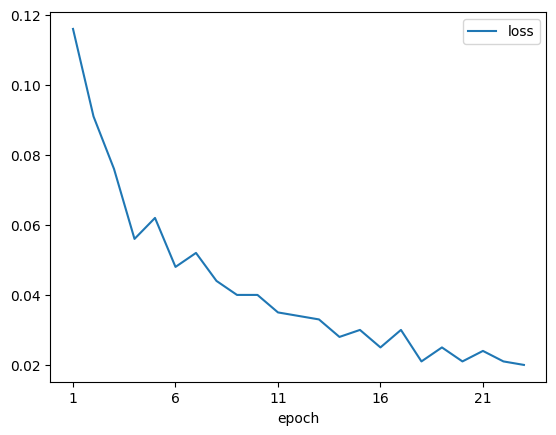

In [89]:
df[df["type"] == "train"].plot(x="epoch", y="loss")

<Axes: xlabel='epoch'>

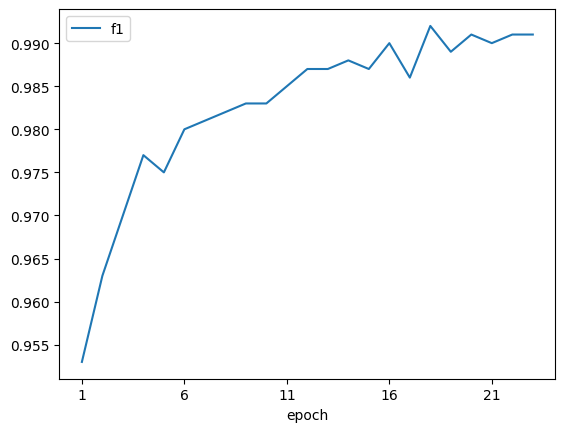

In [90]:
df[df["type"] == "train"].plot(x="epoch", y="f1")

<Axes: >

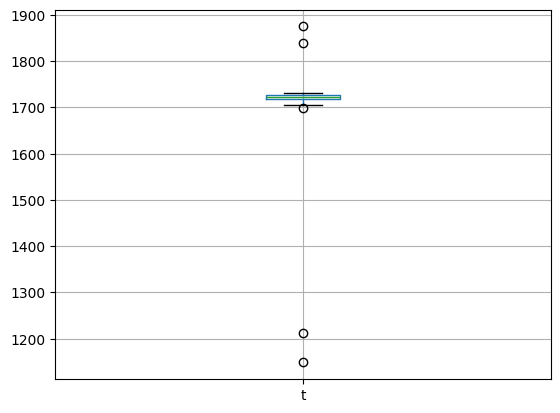

In [115]:
train_df[train_df["type"] == "train"].boxplot(column="t")

<Axes: xlabel='epoch'>

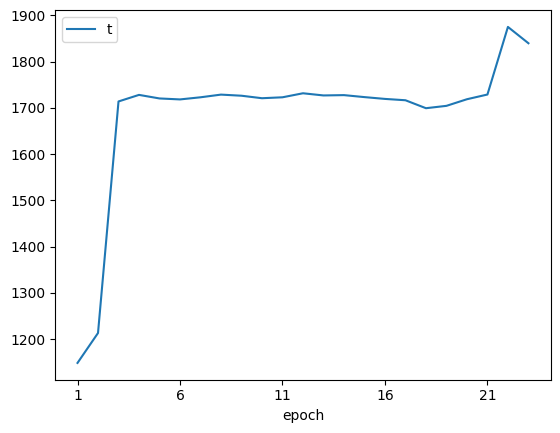

In [117]:
train_df[train_df["type"] == "train"].plot(x="epoch", y="t")

In [116]:
from datetime import timedelta
print(timedelta(seconds=1700))

0:28:20


## Prediction

In [1]:
import sys
prediction_src_path = '/home/poulpos/pigs-documentary/as-fork/PREDICTION'
sys.path.insert(1, prediction_src_path)

In [27]:
from start_prediction import setup_prediction
predicter = setup_prediction("/home/poulpos/pigs-documentary/as-fork/PREDICTION/config")
predicter.init_logger()
predicter.read_config()
predicter.start_prediction()

2023-10-11 15:21:03,431 - training animal-spot - INFO - Config Data: {'src_dir': '/home/poulpos/pigs-documentary/as-fork/ANIMAL-SPOT', 'debug': '', 'model_path': '/home/poulpos/pigs-documentary/rennes/2023-10-11b/model/BOX1-TRANS/ANIMAL-SPOT.pk', 'log_dir': '/home/poulpos/pigs-documentary/rennes/', 'output_dir': '/home/poulpos/pigs-documentary/rennes/', 'sequence_len': '0.50', 'hop': '0.10', 'threshold': '0.75', 'batch_size': '1', 'num_workers': '1', 'no_cuda': '', 'min_max_norm': '', 'latent_extract': '', 'input_file': '/home/poulpos/data/pigs/short_for_predic/BOX1-TRANS'}
2023-10-11 15:21:03,431 - training animal-spot - INFO - Config Data: {'src_dir': '/home/poulpos/pigs-documentary/as-fork/ANIMAL-SPOT', 'debug': '', 'model_path': '/home/poulpos/pigs-documentary/rennes/2023-10-11b/model/BOX1-TRANS/ANIMAL-SPOT.pk', 'log_dir': '/home/poulpos/pigs-documentary/rennes/', 'output_dir': '/home/poulpos/pigs-documentary/rennes/', 'sequence_len': '0.50', 'hop': '0.10', 'threshold': '0.75', 'ba

### Label track

In [3]:
def read_output(file, start_line=1):
    with open(file) as f:
        lines = [line.rstrip() for i, line in enumerate(f) if i >= start_line - 1]
    df = pd.DataFrame(columns=["start", "end", "proba"])
    for line in lines:
        current = {}
        infos = line.split("|")
        if len(infos) >= 2 and infos[1] == "D":
            continue
        if len(infos) < 3:
            print(f"Can't understand the following line\n  {line}")
        infos = [e.strip() for e in infos[2].split(",")]
        for varval in infos:
            [var, val] = varval.split("=")
            if var == "time":
                [start, end] = val.split("-")
                current['start'] = float(start)
                current['end'] = float(end)
            elif var == "prob":
                current['proba'] = float(val)
        row = pd.DataFrame(data={k:[v] for k,v in current.items() if k != "lr"})
        df = pd.concat([df, row], ignore_index=True)
    return df

In [25]:
import pandas as pd
import numpy as np
# df = read_output("/home/poulpos/pigs-documentary/rennes/noisy-vocs-metal_predict_output.log", start_line=12)
# df = read_output("/home/poulpos/pigs-documentary/rennes/grunt-birds-low_predict_output.log", start_line=12)
# df = read_output("/home/poulpos/pigs-documentary/rennes/calls-low-med-noise_predict_output.log", start_line=12)
# df = read_output("/home/poulpos/pigs-documentary/rennes/med-noise--sparse-vocs-metal_predict_output.log", start_line=12)
# df = read_output("/home/poulpos/pigs-documentary/rennes/saturated_predict_output.log", start_line=12)
# df = read_output("/home/poulpos/pigs-documentary/rennes/calls-0000_predict_output.log", start_line=12)
# df = read_output("/home/poulpos/pigs-documentary/rennes/calls-1345_predict_output.log", start_line=12)

In [33]:
import pandas as pd
import numpy as np
df = read_output("/home/poulpos/pigs-documentary/rennes/grunt-squeal-metal_predict_output.log", start_line=12)
# df = read_output("/home/poulpos/pigs-documentary/rennes/mixed_predict_output.log", start_line=12)
# df = read_output("/home/poulpos/pigs-documentary/rennes/pigs-and-cat_predict_output.log", start_line=12)

<Axes: xlabel='start'>

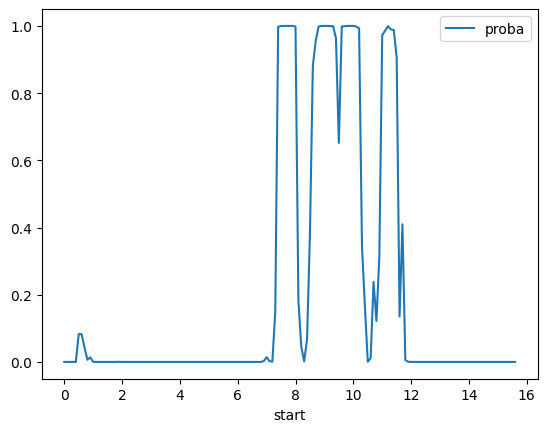

In [34]:
df.plot(x="start", y="proba")

<Axes: xlabel='start'>

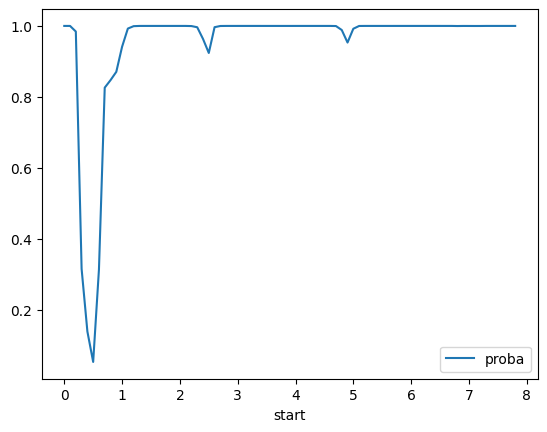

In [18]:
df.plot(x="start", y="proba")

In [35]:
timing = np.sort(pd.unique(pd.concat((df['start'],df['end']))))
timing = pd.DataFrame(zip(timing[:-1], timing[1:]), columns=["start", "end"])
full = pd.DataFrame(columns=["start", "end", "proba"], dtype=np.float64, data=[[0,0,0]])
df["duration"] = df["end"] - df["start"]
timing["duration"] = timing["end"] - timing["start"]
df.sort_values(by='start', inplace=True)
overlap_threshold = .8
for i, slot in timing.iterrows():
    cut = df[(df['end'] >= slot.start) &  (df['start'] <= slot.end)]
    for j, wdw in cut.iterrows():
        dur_inter = min(slot.end, wdw.end) - max(slot.start, wdw.start)
        if dur_inter >= min(slot.duration, wdw.duration) * overlap_threshold:
            full = pd.concat([full, pd.DataFrame(data={'start': [slot.start], 'end': [slot.end], 'proba': [wdw.proba]})], ignore_index=True)

full['mid'] = full.apply(lambda r: (r.end + r.start)/2, axis=1)
meanf = full.groupby(by=["mid"]).agg('max').rename(columns={'proba': 'mean_proba'})
meanf.reset_index(inplace=True)

<Axes: xlabel='mid'>

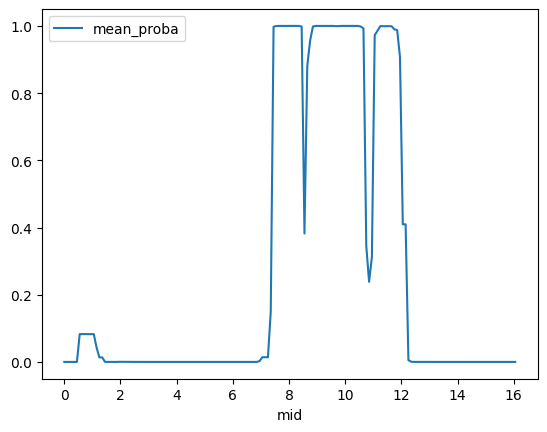

In [36]:
meanf.plot(x="mid", y="mean_proba")

In [32]:
prev_i = -1
start = 0
end = 0
for i,row in meanf[meanf["mean_proba"] > .8].iterrows():
    if i != prev_i + 1:
        print(f"{start} -> {end}    {end-start:.3f}")
        start = row.start
    end = row.end
    prev_i = i
print(f"{start} -> {end}")

0 -> 0    0.000
0.0 -> 0.6    0.600
1.6 -> 3.3


In [15]:
import os
import matplotlib.pyplot as plt
import librosa
import numpy as np
pigs_out_dir = "/home/poulpos/pigs-documentary/rennes"
pigs_wav_dir = "/home/poulpos/data/pigs/short_for_predic/"
origin = "noisy-vocs-metal"
output = os.path.join(pigs_out_dir, origin + "_predict_output.log")
wave = os.path.join(pigs_wav_dir, origin + ".wav")

In [16]:
pred_df = read_output(output, start_line=12)

ValueError: negative dimensions are not allowed

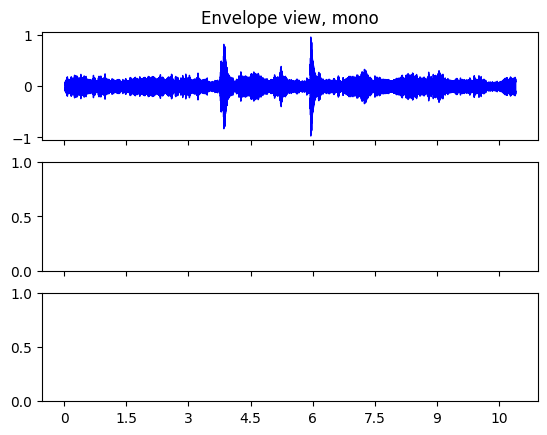

In [17]:
y, sr = librosa.load(wave)
fig, ax = plt.subplots(nrows=3, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0], color="blue")
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()
xx = np.arange(0, len(y)/sr, 0.2)
yy = np.array([-1, 1])
proba = np.array([pred_df["proba"]])
proba = np.concatenate((proba, np.zeros((1,xx.shape[0] - proba.shape[1]-1))), axis=1)
ax[1].pcolormesh(xx, yy, proba, cmap='RdBu', vmin=0, vmax=1)
proba = np.concatenate((proba[0], np.array([0])))
ax[2].plot(xx, proba)
plt.show()

# Spectro

## Absolute values

In [1]:
import sys
prediction_src_path = '/home/poulpos/pigs-documentary/as-fork/ANIMAL-SPOT'
sys.path.insert(1, prediction_src_path)

In [2]:
from vis.spec import ClippedAudioDataset
import numpy as np

SystemError: initialization of _internal failed without raising an exception

In [8]:
cad = ClippedAudioDataset("calls-0000", working_dir="/home/poulpos/data/pigs/short_for_predic/BOX1-FARMEIK/")

In [9]:
for i in range(len(cad)):
    print(f"{cad[i][1]} :: {cad[i][0].sum()}")

noise-low :: 17.571697235107422
noise-med :: 89.70050048828125
noise-low :: 14.796531677246094
noise-low :: 24.141067504882812
grunt-low :: 33.15304183959961
short :: 9.931573867797852
noise-low :: 14.730072021484375
grunt-low :: 24.329723358154297
noise-med :: 248.52249145507812
long :: 18.10748291015625
squeal-high :: 429.08868408203125
squeal-sat :: 701.0927734375
grunt-low :: 34.46598815917969


In [11]:
import numpy as np
10*np.log10(33/18 - 1)

-0.7918124604762486

In [8]:
np.argsort([cad[i].sum() for i in range(len(cad))])

array([ 0,  6,  4, 10,  3,  7,  8,  5,  2,  9,  1])

In [9]:
import matplotlib.pyplot as plt

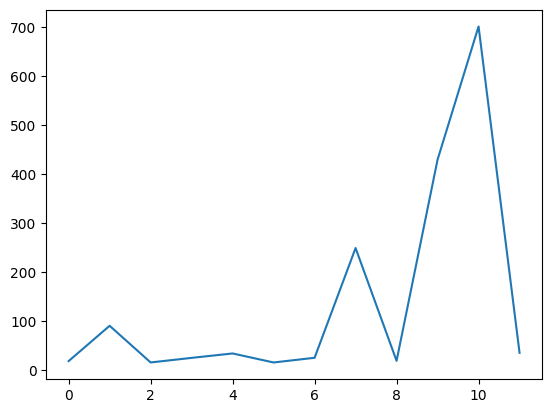

In [10]:
plt.plot([cad[i].sum() for i in range(len(cad))])

In [5]:
import pandas as pd

In [6]:
l = pd.read_csv("/run/media/poulpos/PIGS-KU-MA1/bandpassed/BOX1-TRANS/BOX1-TRANS_20230625_205802.bg.clean.txt", sep="\t", names=["start","end","label", "index"])

In [7]:
l.head()

start        end  label  index
0      start        end  label  index
1  10.597833  12.100704      m      1
2  15.806059  20.962461      m      2
3  27.518089  29.202341      m      3
4  41.613984  45.630278      c      4

## AS generation

### No noise augmentation

In [3]:
cad = ClippedAudioDataset("target-HF_3965_2023_IASPIASPReunionReunSow98Pig84_0_322", working_dir="/home/poulpos/pigs-documentary/rennes/2023-10-10b/")
spectrogram = cad[0][0].squeeze().numpy().T

/home/poulpos/.pyenv/versions/pigs/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


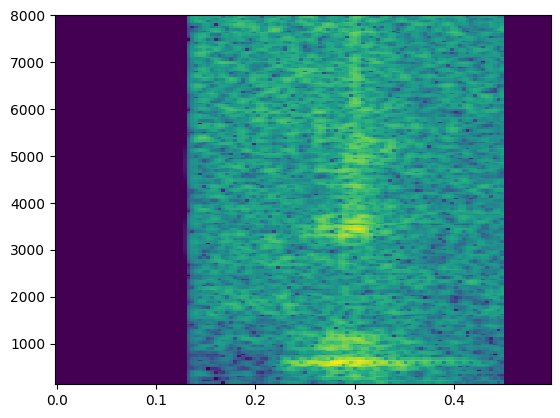

In [4]:
import matplotlib.pyplot as plt
import numpy as np
hop_length=172
sr = 44100
fmin=150
fmax=8000
t = np.arange(0, spectrogram.shape[1]) * hop_length / sr
f = np.linspace(fmin, fmax, num=spectrogram.shape[0])
axes = plt.gca()
img = axes.pcolormesh(t, f, spectrogram, shading="auto")

### With noise augmentation

In [1]:
import sys
prediction_src_path = '/home/poulpos/pigs-documentary/as-fork/ANIMAL-SPOT'
sys.path.insert(1, prediction_src_path)

In [2]:
from vis.spec import ClippedAudioDataset
import numpy as np

In [11]:
cad = ClippedAudioDataset("target-HF_3965_2023_IASPIASPReunionReunSow98Pig84_0_322",
                          working_dir="/home/poulpos/pigs-documentary/rennes/2023-10-10b/",
                         noise_files=["/home/poulpos/pigs-documentary/rennes/2023-10-10b/background~BOX1-FARMEIK_20230802_000000~c~11.wav"],
                         augmentation=True,
                         min_snr=0,
                         max_snr=-1)
spectrogram = cad[0][0].squeeze().numpy().T

added
tensor(5.1914)
tensor(39.4458)
tensor([0.1657])


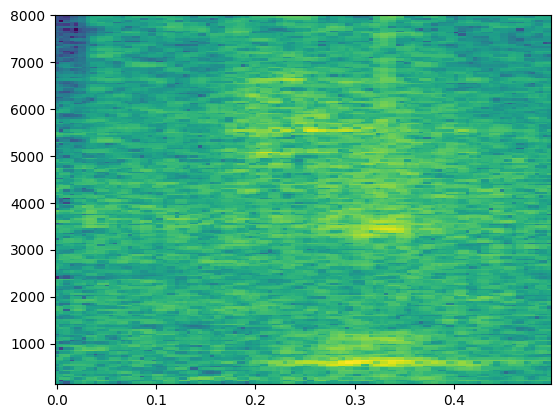

In [12]:
import matplotlib.pyplot as plt
import numpy as np
hop_length=172
sr = 44100
fmin=150
fmax=8000
t = np.arange(0, spectrogram.shape[1]) * hop_length / sr
f = np.linspace(fmin, fmax, num=spectrogram.shape[0])
axes = plt.gca()
img = axes.pcolormesh(t, f, spectrogram, shading="auto")